## Supervised Expert Learning on Spambase Dataset

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

### Supervised Experts Class

In [13]:
class Experts:
    def __init__(self, epochs=1, alpha=0.1):
        """Initialize 6 expert models with their respective hyperparameters."""
        self.epochs = epochs  # Number of training passes over the dataset
        self.alpha = alpha    # Fixed-share parameter for online updates

        self.experts = {
            "LogReg_Default": LogisticRegression(random_state=42),
            "NaiveBayes": GaussianNB(),
            "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
            "SVM": SVC(kernel='rbf', probability=True, random_state=42),
            "MLP": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
            "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
        }

        # Dictionaries for storing losses over epochs for each expert
        self.train_loss = {name: [] for name in self.experts}
        self.test_loss = {name: [] for name in self.experts}

    def train(self, X_train, y_train, X_test, y_test):
        """Train all experts iteratively over multiple epochs and log train & test loss."""
        y_train = y_train.ravel()  # Ensure 1D array
        y_test = y_test.ravel()    # Ensure 1D array

        for epoch in range(self.epochs):
            for name, model in self.experts.items():
                model.fit(X_train, y_train)  # Retrain each epoch

                # Compute train loss (using log_loss if model supports probability predictions)
                if hasattr(model, "predict_proba"):
                    train_probs = model.predict_proba(X_train)
                    t_loss = log_loss(y_train, train_probs)
                else:
                    train_preds = model.predict(X_train)
                    # Convert predictions to probabilities (0/1); note this is crude but works for logging
                    train_probs = np.clip(train_preds, 1e-15, 1 - 1e-15)
                    t_loss = log_loss(y_train, train_probs)
                self.train_loss[name].append(t_loss)

                # Compute test loss similarly
                if hasattr(model, "predict_proba"):
                    test_probs = model.predict_proba(X_test)
                    te_loss = log_loss(y_test, test_probs)
                else:
                    test_preds = model.predict(X_test)
                    test_probs = np.clip(test_preds, 1e-15, 1 - 1e-15)
                    te_loss = log_loss(y_test, test_probs)
                self.test_loss[name].append(te_loss)

            # print(f"Epoch {epoch + 1}/{self.epochs} completed.")

    def plot_losses(self):
        """Generate individual train and test loss plots for each expert across epochs."""
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
        axes = axes.flatten()

        for idx, name in enumerate(self.experts.keys()):
            ax = axes[idx]
            ax.plot(range(1, self.epochs + 1), self.train_loss[name], label="Train Loss", linestyle='-', marker='o')
            ax.plot(range(1, self.epochs + 1), self.test_loss[name], label="Test Loss", linestyle='--', marker='s')
            ax.set_title(name)
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Log Loss")
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        plt.show()

    def run(self, X_train, y_train, X_test, y_test):
        """Run training and plot the loss curves for each expert."""
        self.train(X_train, y_train, X_test, y_test)
        self.plot_losses()

    def predict_experts(self, X):
        """Get predictions from all experts as a dictionary."""
        preds = {}
        for name, model in self.experts.items():
            preds[name] = model.predict(X)
        return preds

    def online_aggregation(self, X, y, method='static', eta=0.5):
        """
        Online aggregation: process data sample-by-sample.
        
        Parameters:
          X: Array of shape (n_samples, n_features)
          y: Array of true labels, shape (n_samples,)
          method: 'static' (exponential weights) or 'fixed_share'
          eta: Learning rate
        
        Returns:
          Dictionary containing:
            - weights_over_time: Array tracking weight evolution.
            - aggregator_preds: Aggregator's predictions per sample.
            - aggregator_losses: 0-1 losses for aggregator per sample.
            - aggregator_cum_loss: Cumulative loss over samples.
            - expert_cum_loss: Cumulative losses of each expert.
            - expert_names: List of expert names.
        """
        y = y.ravel()
        expert_names = list(self.experts.keys())
        n_experts = len(expert_names)
        n_samples = X.shape[0]

        # Initialize arrays to record metrics
        weights_over_time = np.zeros((n_samples + 1, n_experts))
        aggregator_preds = np.zeros(n_samples, dtype=int)
        aggregator_losses = np.zeros(n_samples)
        expert_losses = np.zeros((n_samples, n_experts))

        # Start with uniform weights
        weights = np.ones(n_experts) / n_experts
        weights_over_time[0] = weights.copy()

        # Process each sample online
        for t in range(n_samples):
            x_t = X[t].reshape(1, -1)
            y_t = y[t]

            
            # Get predictions from all experts
            preds_dict = self.predict_experts(x_t)
            expert_preds = np.array([preds_dict[name][0] for name in expert_names])

            # Aggregator prediction via weighted majority vote
            p_label_1 = np.sum(weights * (expert_preds == 1))
            agg_pred = 1 if p_label_1 >= 0.5 else 0
            aggregator_preds[t] = agg_pred
            aggregator_losses[t] = 1 if agg_pred != y_t else 0

            # Record each expert's 0-1 loss on this sample
            for i in range(n_experts):
                expert_losses[t, i] = 1 if expert_preds[i] != y_t else 0

            # Update weights based on expert losses
            if method == 'static':
                updated_weights = weights * np.exp(-eta * expert_losses[t, :])
                weights = updated_weights / np.sum(updated_weights)
            elif method == 'fixed_share':
                updated_weights = weights * np.exp(-eta * expert_losses[t, :])
                # Fixed-share redistribution: redistribute a fraction alpha uniformly
                shared_weights = self.alpha * np.mean(updated_weights)
                updated_weights = (1 - self.alpha) * updated_weights + shared_weights
                weights = updated_weights / np.sum(updated_weights)
            else:
                raise ValueError("Method must be 'static' or 'fixed_share'")

            weights_over_time[t + 1] = weights.copy()

        aggregator_cum_loss = np.cumsum(aggregator_losses)
        expert_cum_loss = np.cumsum(expert_losses, axis=0)
        
        self.results = {
            "weights_over_time": weights_over_time,
            "expert_cum_loss": expert_cum_loss,
            "aggregator_cum_loss": aggregator_cum_loss,
            "expert_names": expert_names
        }
    
    def plot_aggregator_info(self):
        """
        Plots aggregator and expert information from online aggregation.
        
        Parameters:
        results: Dictionary output from the online_aggregation method containing:
            - weights_over_time: shape (n_samples+1, n_experts)
            - aggregator_cum_loss: shape (n_samples,)
            - expert_cum_loss: shape (n_samples, n_experts)
            - expert_names: list of expert names
        """
        weights = self.results["weights_over_time"]
        aggregator_cum_loss = self.results["aggregator_cum_loss"]
        expert_cum_loss = self.results["expert_cum_loss"]
        expert_names = self.results["expert_names"]
        
        n_samples = weights.shape[0] - 1

        # Plot 1: Evolution of Expert Weights
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        for i, name in enumerate(expert_names):
            plt.plot(range(n_samples + 1), weights[:, i], label=name)
        plt.xlabel("Iteration")
        plt.ylabel("Weight")
        plt.title("Evolution of Expert Weights")
        plt.legend()
        plt.grid(True)

        # Plot 2: Cumulative Loss (Aggregator vs. Experts)
        plt.subplot(2, 1, 2)
        plt.plot(range(n_samples), aggregator_cum_loss, label="Aggregator Cumulative Loss", 
                linewidth=2, color="black")
        for i, name in enumerate(expert_names):
            plt.plot(range(n_samples), expert_cum_loss[:, i], 
                    label=f"{name} Cumulative Loss", linestyle="--")
        plt.xlabel("Iteration")
        plt.ylabel("Cumulative Loss")
        plt.title("Cumulative Loss vs. Iterations")
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

### Import Dataset

In [14]:
# Fetch dataset 
spambase = fetch_ucirepo(id=94) 

# Data (as pandas dataframes) 
spambase_X = spambase.data.features 
spambase_y = spambase.data.targets 

# Convert to NumPy arrays
X_spam = spambase_X.to_numpy()
y_spam = spambase_y.to_numpy()

# Train/test split
X_spam_train, X_spam_test, y_spam_train, y_spam_test = train_test_split(
    X_spam, y_spam, test_size=0.2, random_state=42, stratify=y_spam
)

# Scale features
scaler_spam = StandardScaler().fit(X_spam_train)
X_spam_train = scaler_spam.transform(X_spam_train)
X_spam_test = scaler_spam.transform(X_spam_test)

### Offline Training and Evaluation of Experts

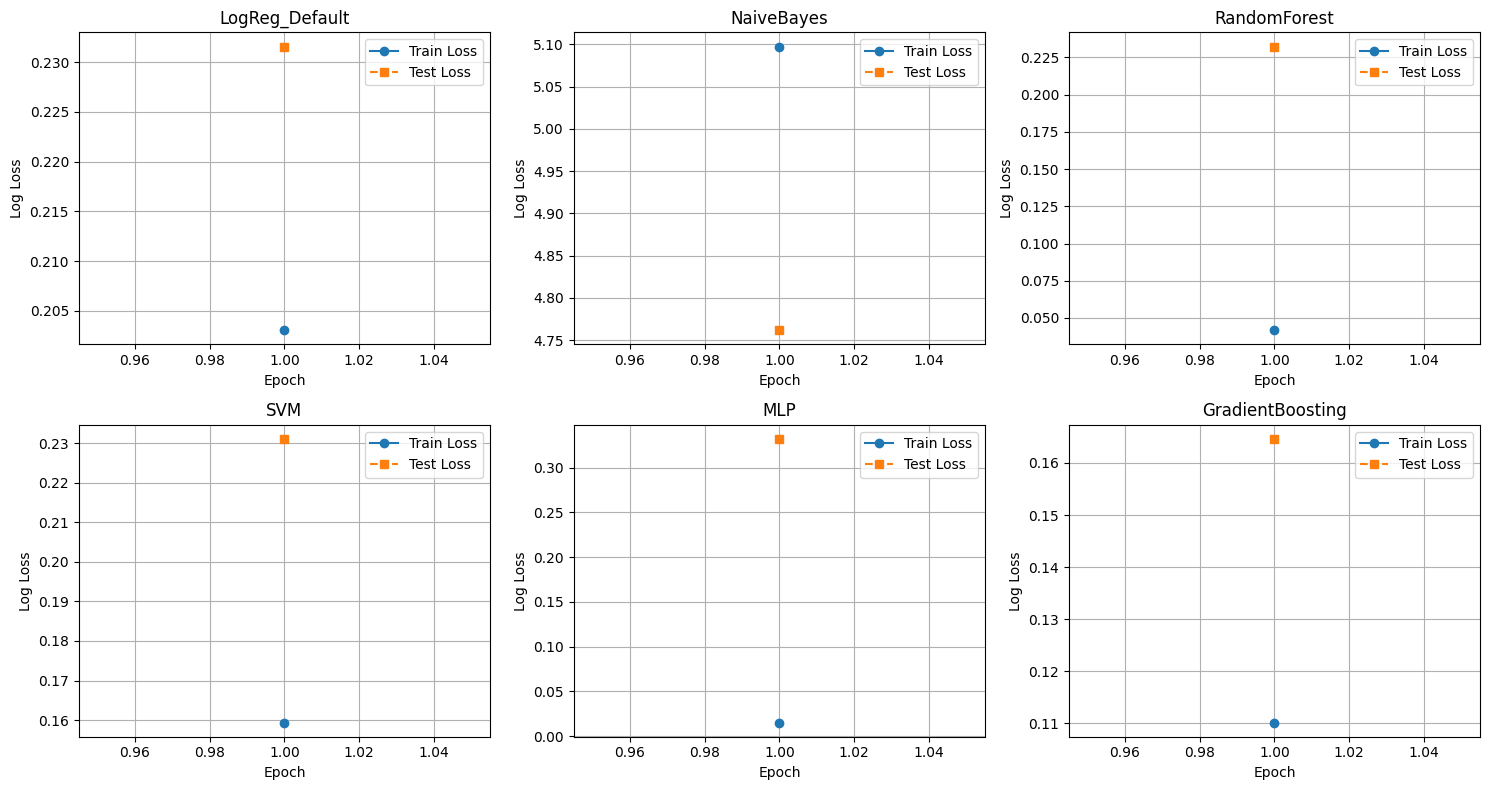

In [15]:
# Run the expert offline model training and evaluation of supervised experts
experts = Experts(epochs=1)
experts.run(X_spam_train, y_spam_train, X_spam_test, y_spam_test)

### Online Training and Evaluation of Experts

#### Static Weight Share

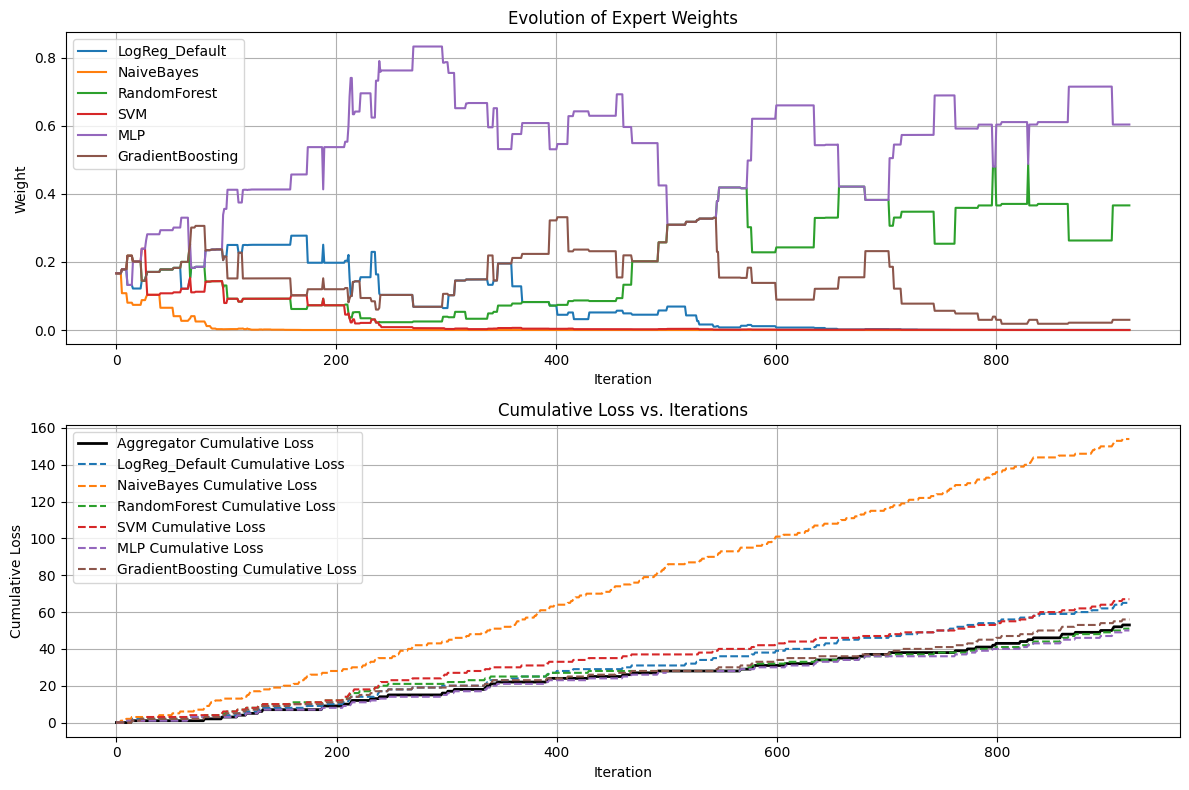

In [16]:
# Run online aggregation on the test set
experts.online_aggregation(X_spam_test, y_spam_test, method='static', eta=0.5)
# Plot the evolution of expert weights and the cumulative aggregator loss
experts.plot_aggregator_info()

#### Fixed Weight Share

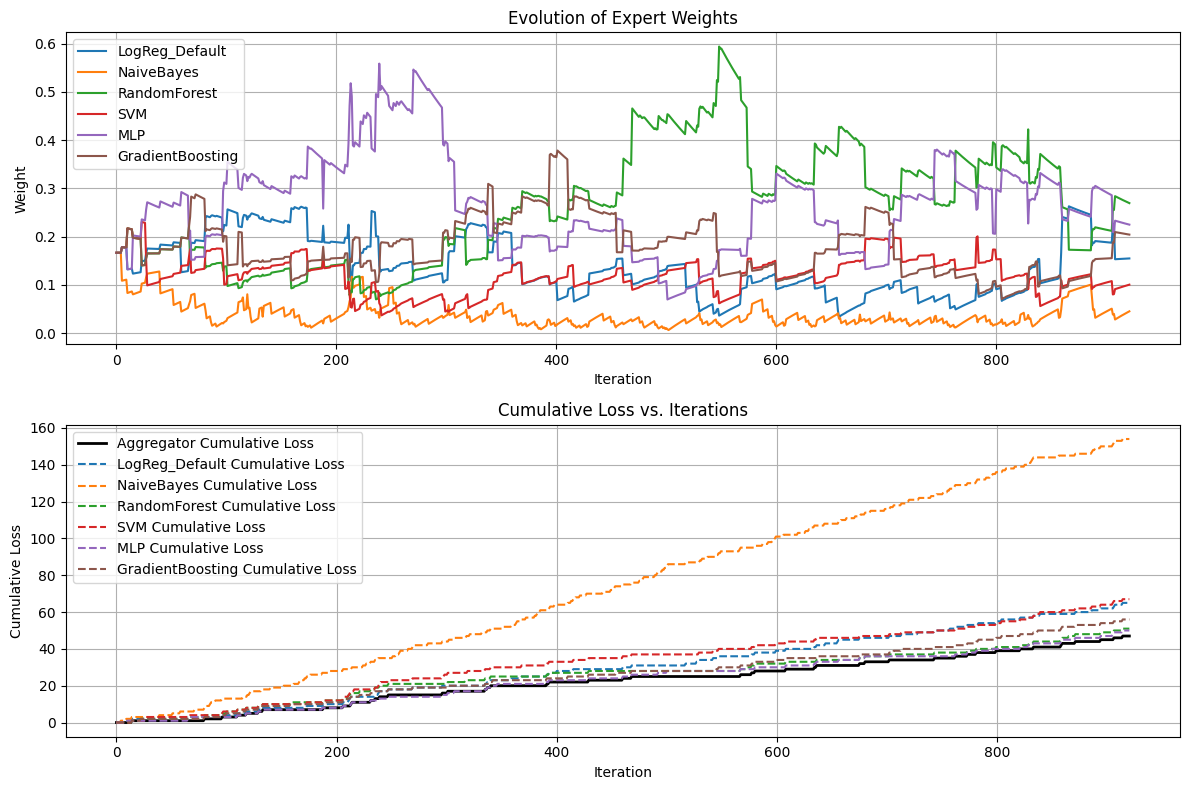

In [17]:
experts.alpha = 0.01
experts.online_aggregation(X_spam_test, y_spam_test, method='fixed_share', eta=0.5)
experts.plot_aggregator_info()

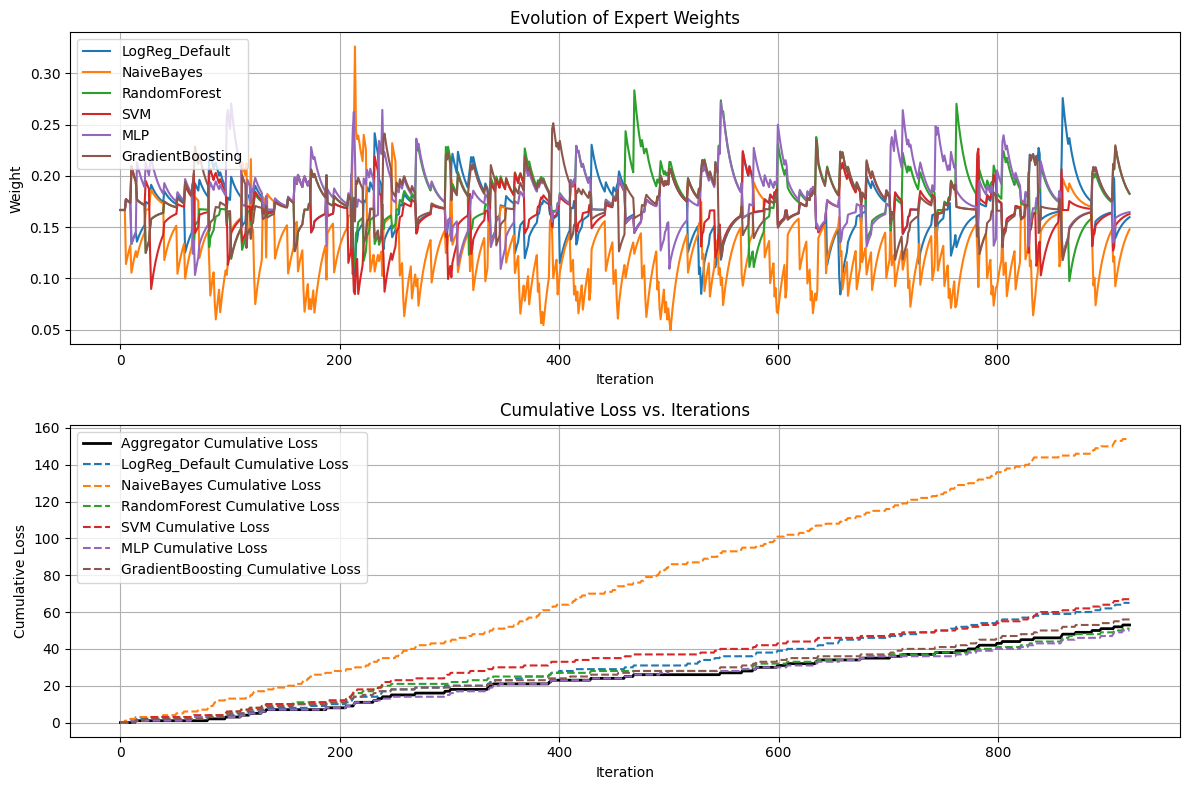

In [18]:
#alpha = 0.25
experts.alpha = 0.1
experts.online_aggregation(X_spam_test, y_spam_test, method='fixed_share', eta=0.5)
experts.plot_aggregator_info()

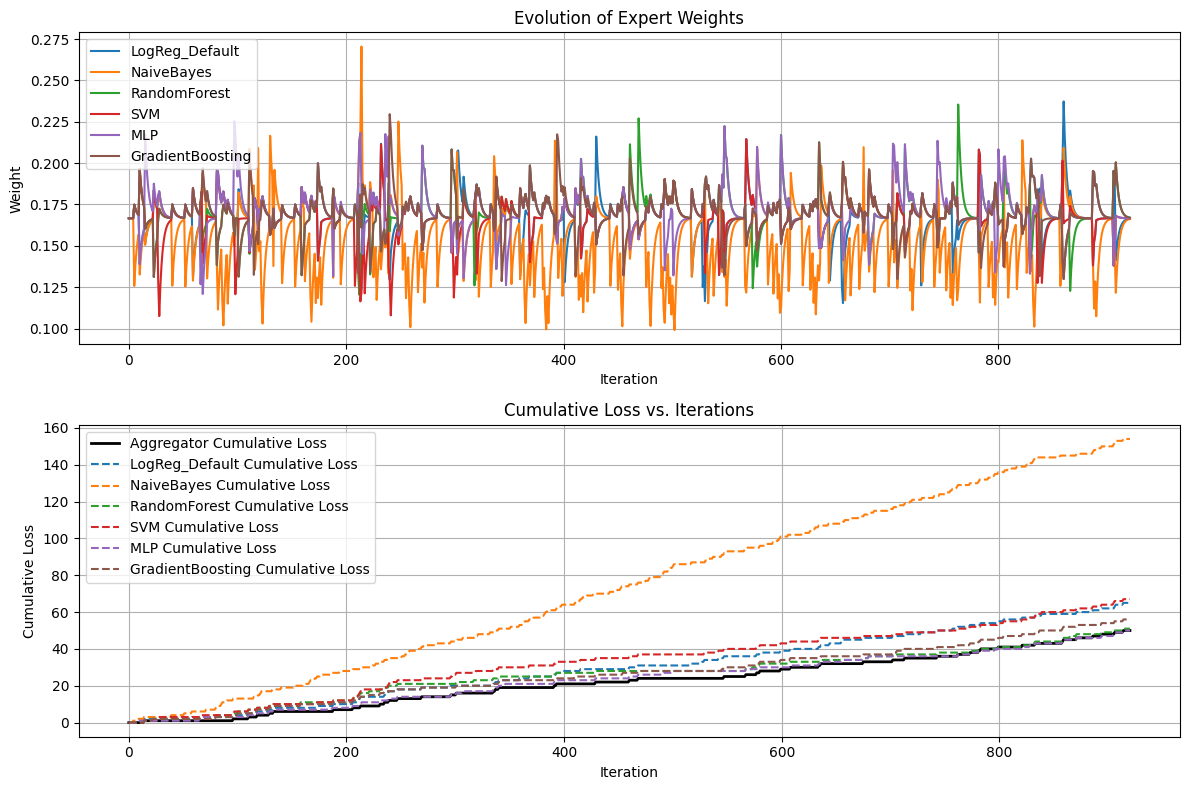

In [19]:
#alpha = 0.5
experts.alpha = 0.3
experts.online_aggregation(X_spam_test, y_spam_test, method='fixed_share', eta=0.5)
experts.plot_aggregator_info()